<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/345_bayesian_prediction.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(bayesian_prediction_notebook)=
# La predizione bayesiana

L'analisi bayesiana si prefigge diversi obiettivi, tra cui la rielaborazione della distribuzione a posteriori dei parametri, la verifica delle ipotesi e la previsione dei dati futuri. Dopo aver acquisito le distribuzioni a posteriori dei parametri, siamo in grado di formulare anticipazioni in merito alle caratteristiche dei dati futuri. Ciò ci conduce a sviluppare una "distribuzione predittiva a posteriori", che costituisce uno strumento di verifica e validazione del modello tramite il confronto tra le previsioni del modello stesso e i dati effettivamente osservati nel campione. In sostanza, facciamo uso del modello corrente per effettuare previsioni riguardo ai possibili dati futuri e successivamente confrontiamo tali previsioni con i dati realmente rilevati nel campione. Se le previsioni del modello risultano coerenti con i dati effettivamente osservati, allora possiamo concludere che il modello sia adeguato per una rappresentazione accurata dei dati.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats 
import pymc as pm
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

## La distribuzione predittiva a posteriori

Per illustrare il concetto di "distribuzione predittiva a posteriori", esploreremo un caso specifico: il modello beta-binomiale. All'interno di questa cornice, il parametro $\theta$ (rappresentante la probabilità di successo) segue una distribuzione a priori modellata con una distribuzione Beta, mentre la verosimiglianza è descritta attraverso una distribuzione Binomiale. I dati sono costiuiti dal numero $y$ di successi in $n$ prove Bernoulliane indipendenti.

Prendiamo in considerazione un esempio discusso in precedenza, relativo al numero di artisti della generazione X o successive rappresentati al MOMA. In un campione di 100 artisti, abbiamo osservato che solamente 14 di essi appartengono a tali generazioni. Di conseguenza, possiamo parlare di 14 "successi" in 100 prove Bernoulliane indipendenti. Supponiamo ora di voler esaminare un nuovo campione casuale composto da $m$=20 artisti all'interno del MOMA. L'obiettivo è stimare quanti di essi apparterranno alla generazione X o successive. In generale, vogliamo formulare delle previsioni riguardanti i risultati di nuovi campioni potenziali costituiti da $m$ osservazioni.

Definiamo una variabile casuale $\tilde{Y}$ che rappresenta il numero di "successi" in un nuovo campione di $m$ prove. Quindi, in un nuovo campione, $\tilde{Y}$ può assumere valori come $\tilde{y}_1$ (ad esempio, 12), $\tilde{y}_2$ (ad esempio, 7), e così via. L'obiettivo consiste nel calcolare le probabilità associate a ciascuno dei valori possibili di $\tilde{Y}$, compresi tra 0 e 20 inclusi. Questa distribuzione di probabilità discreta prende il nome di "distribuzione predittiva a posteriori", $p(\tilde{Y} = \tilde{y} \mid Y = y)$, ed esprime la probabilità attribuita a ciascuno dei possibili valori di $\tilde{Y}$ (0, 1, ..., 19, 20) nei futuri campioni potenziali costituiti da $m$ = 20 osservazioni.

In questo capitolo, esamineremo tre diverse strategie per conseguire questo obiettivo:

1. **Approccio analitico**: Risolveremo la distribuzione attraverso metodi matematici.
2. **Simulazione**: Utilizzeremo tecniche di simulazione per ottenere i risultati desiderati.
3. **Campionamento MCMC**: Applicheremo il metodo di campionamento MCMC per stimare la distribuzione predittiva a posteriori.

Tutti e tre i metodi risultano equivalenti e conducono agli stessi risultati. Tuttavia, è importante notare che l'approccio MCMC ci consente di ottenere la soluzione in maniera diretta, specialmente quando non è disponibile una soluzione analitica, come accade in casi al di fuori del contesto delle famiglie coniugate.

### Derivazione analitica

Nel contesto considerato, la variabile casuale $\tilde{Y}$ segue una distribuzione che dipende dal parametro $\theta$, e le informazioni su $\theta$ sono contenute nella distribuzione a posteriori $p(\theta \mid y)$. Applicando la regola della probabilità congiunta, possiamo rappresentare la distribuzione congiunta delle variabili $\tilde{y}$ e $\theta$ come:

$$
p(\tilde{y}, \theta \mid y) = p(\tilde{y} \mid \theta, y) p(\theta \mid y).
$$

Assumendo che le osservazioni passate $y$ e le future osservazioni $\tilde{y}$ siano indipendenti dato il valore di $\theta$, possiamo semplificare l'espressione come:

$$
p(\tilde{y}, \theta \mid y) = p(\tilde{y} \mid \theta) p(\theta \mid y).
$$

La distribuzione predittiva a posteriori $p(\tilde{y} \mid y)$ è ottenuta integrando la distribuzione congiunta rispetto al parametro $\theta$:

$$
p(\tilde{y} \mid y) = \int_{\theta} p(\tilde{y} \mid \theta) p(\theta \mid y) \,\operatorname{d}\!\theta.
$$

Nel caso del modello beta-binomiale, la probabilità $p(\tilde{y} \mid \theta)$ segue una distribuzione binomiale con parametri $m$ e $\theta$, mentre la distribuzione a posteriori $p(\theta \mid y)$ è una distribuzione Beta con parametri $\alpha + y$ e $\beta + n - y$. Risolvendo l'integrale, otteniamo la distribuzione predittiva a posteriori:

$$
\begin{align}
p(\tilde{y} \mid y) &= \int_0^1 p(\tilde{y} \mid \theta) p(\theta \mid y)\,\operatorname{d}\!\theta \notag\\
&= \int_0^1 \binom{m}{\tilde{y}} \theta^{\tilde{y}} (1-\theta)^{m-\tilde{y}} \cdot \frac{1}{B(a+y, b+n-y)} \theta^{a+y-1} (1-\theta)^{b+n-y-1} \,\operatorname{d}\!\theta \notag\\
&= \binom{m}{\tilde{y}} \frac{B(\tilde{y}+a+y,b+n-y+m-\tilde{y})}{B(a+y, b+n-y)},
\end{align}
$$ 

dove $B$ rappresenta la funzione Beta e $\binom{m}{\tilde{y}}$ denota il coefficiente binomiale.

In conclusione, nel contesto del modello beta-binomiale, la distribuzione predittiva a posteriori corrisponde a una distribuzione di probabilità discreta chiamata *distribuzione beta-binomiale* con parametri $m$, $\alpha + y$ e $\beta + n - y$:

$$
f(\tilde{y} \mid y) = \binom{m}{\tilde{y}} \frac{B(a+ y + \tilde{y}, b + n - y + m - \tilde{y})}{B(a+y, b+n-y)}.
$$ (eq-beta-binomial-distr)


#### Un esempio concreto

Nell'esempio relativo agli artisti del MOMA, la verosimiglianza dei dati segue una distribuzione binomiale, con 14 successi su 100 prove. La distribuzione a priori per il parametro di successo $\theta$ è una distribuzione Beta(4, 6). Di conseguenza, la distribuzione a posteriori sul parametro $\theta$ è una distribuzione Beta(18, 92).

L'obiettivo che ci poniamo è calcolare la distribuzione predittiva a posteriori per un nuovo campione con un numero di osservazioni $m$ = 20.

Con riferimento all'eq. {eq}`eq-beta-binomial-distr`, sappiamo che la distribuzione predittiva a posteriori assume la forma di una distribuzione beta-binomiale con i parametri $m$, $\alpha + y$ e $\beta + n - y$. Qui, $m$ denota il numero di prove nel nuovo campione, $\alpha$ e $\beta$ rappresentano i parametri della distribuzione a priori, mentre $y$ e $n$ indicano rispettivamente il numero di successi e il numero totale di prove nel campione attuale. Nell'esempio in esame, otteniamo i seguenti valori per i parametri della distribuzione beta-binomiale: $m = 20$, $\alpha' = 4 + 14 = 18$, $\beta' = 6 + 100 - 14 = 92$.

Possiamo rappresentare graficamente la distribuzione predittiva a posteriori che abbiamo definito usando funzione `betabinom.pmf`.

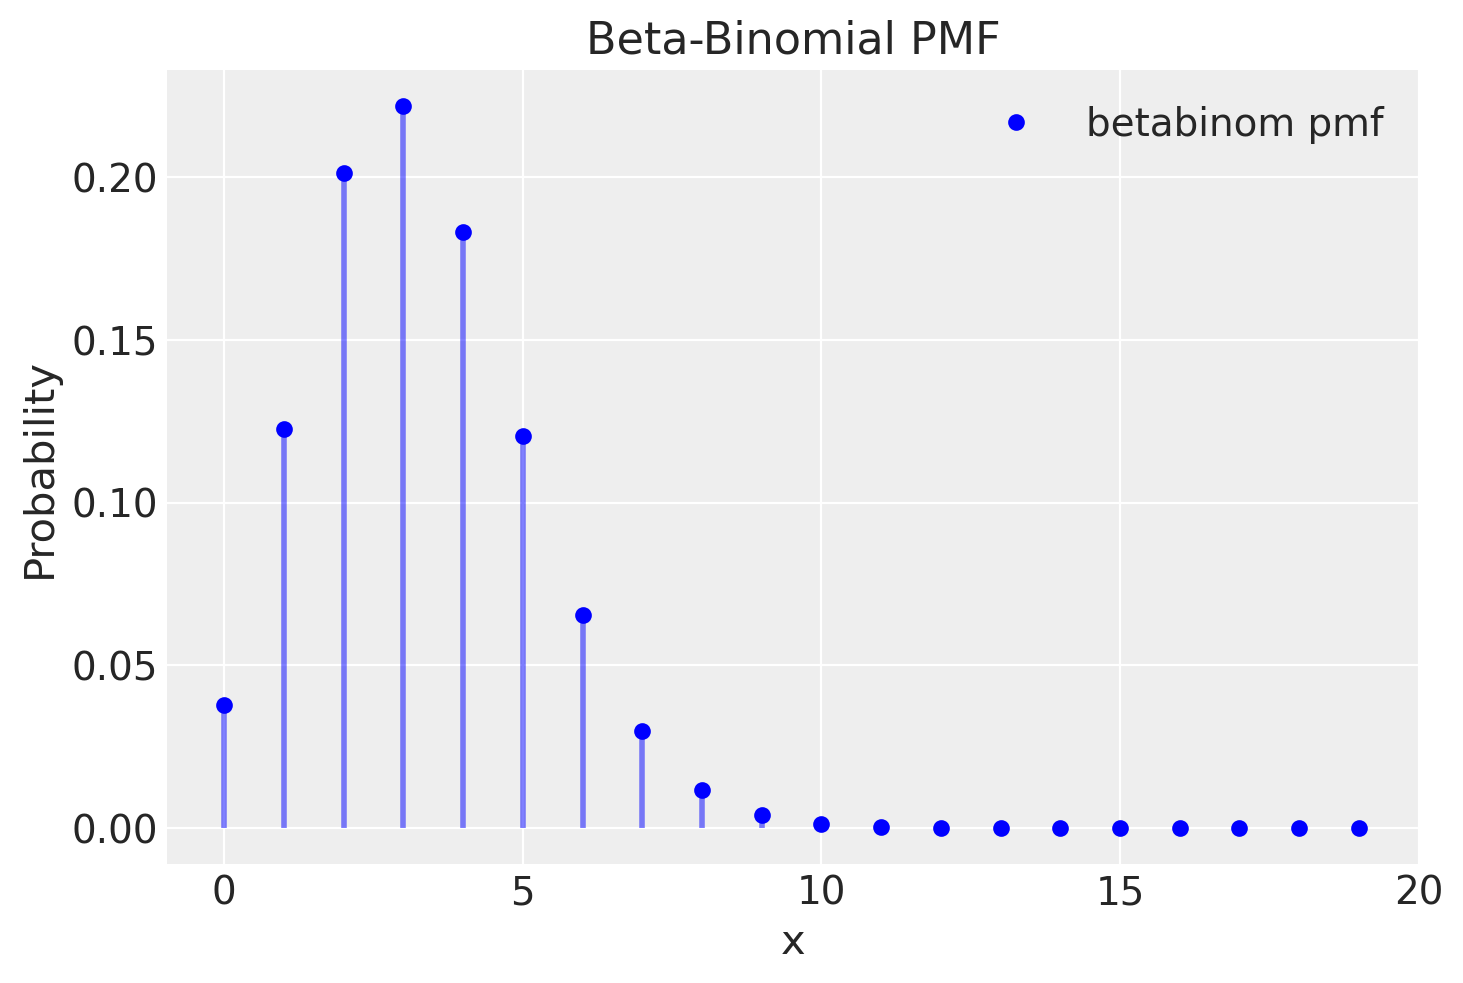

In [24]:
alpha = 4
beta = 6
y = 14
n = 100
alpha_prime = alpha + y
beta_prime = beta + n - y
m = 20
x = np.arange(0, 20)

plt.plot(
    x, stats.betabinom.pmf(x, m, alpha_prime, beta_prime), "bo", ms=5, label="betabinom pmf"
)
_ = plt.vlines(
    x, 0, stats.betabinom.pmf(x, m, alpha_prime, beta_prime), colors="b", lw=2, alpha=0.5
)

# Set x-ticks to be every 5 units
plt.xticks(np.arange(0, 21, 5))

plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Beta-Binomial PMF')
plt.legend()
plt.show()

La distribuzione predittiva a posteriori, mostrata nella figura precedente, fornisce informazioni sulla probabilità di osservare $0, 1, \dots, 20$ successi su $m = 20$ prove in un futuro campione di $m$ = 20 osservazioni. Queste probabilità sono valutate tenendo conto dei dati osservati nel campione corrente (14 successi su 100 prove) e delle nostre opinioni iniziali sulla plausibilità dei possibili valori di $\theta$ (rappresentate dalla distribuzione a priori Beta(4, 6)). In altre parole, la distribuzione predittiva a posteriori ci offre una visione delle possibili frequenze di successo che potremmo osservare nei futuri campioni, basandoci sulle nostre conoscenze attuali e sull'esperienza passata.

La distribuzione predittiva a posteriori rivela che, nei potenziali campioni futuri composti da 20 osservazioni, il valore $\tilde{y}$ con la probabilità più elevata è 3. Tuttavia, la distribuzione predittiva a posteriori ci fornisce informazioni sulla probabilità relativa di ciascuno dei possibili valori futuri di $\tilde{y}$. Questi valori rappresentano il numero di artisti della Generazione X o successive che potrebbero trovarsi all'interno di un futuro campione di 20 osservazioni.

Una volta ottenuta la distribuzione predittiva a posteriori possiamo rispondere a ulteriori domande. Ad esempio, Qual è la probabilità a posteriori che almeno 5 degli 20 artisti siano della generazione X, ossia $P(\tilde{Y} \geq 5 \mid Y = 14)$?

Il risultato è dato da $\sum_i(P(\tilde{Y} = \tilde{y}_i)$, con $i \in 5, \dots, 20$.

In [5]:
1 - stats.betabinom.cdf(4, m, alpha_prime, beta_prime).sum()

0.23298739435887628

È altresì possibile calcolare il valore atteso della distribuzione predittiva a posteriori, cioè il numero previsto di artisti appartenenti alla Generazione X o successiva in un campione casuale di 20.

In [6]:
x = np.arange(0, 21)
px = stats.betabinom.pmf(np.arange(0, 21), m, alpha_prime, beta_prime)

ev = sum(x * px)
print(ev)

3.272727272727284


In conclusione, per il caso beta-binomiale, possiamo affermare che la previsione bayesiana di una nuova osservazione futura è rappresentata dalla distribuzione beta-binomiale con parametri $m$, $\alpha + y$ e $\beta + n - y$. Qui, $m$ rappresenta il numero di prove nel nuovo campione, $\alpha$ e $\beta$ sono i parametri della distribuzione a priori, e $y$ e $n$ sono le caratteristiche del campione attuale. In altre parole, la distribuzione beta-binomiale ci fornisce una stima delle possibili frequenze di successi che potremmo osservare in futuri campioni, tenendo conto dei dati osservati e delle nostre conoscenze iniziali sulla probabilità di successo.

### Metodo basato sulla simulazione

In situazioni in cui non è possibile ottenere esattamente la distribuzione predittiva a posteriori, è comunque possibile ottenere un campione casuale di valori dalla distribuzione mediante simulazione. Nel caso in esame, supponiamo di voler generare un campione casuale di $n$ osservazioni dalla distribuzione predittiva a posteriori. Per farlo, possiamo seguire due fasi di simulazione:

1. Estraiamo casualmente $n$ valori del parametro $\theta$ dalla distribuzione a posteriori $p(\theta \mid y)$.
2. Utilizziamo i valori del parametro $\theta$ estratti per generare $n$ valori casuali di $\tilde{y}$, utilizzando il modello binomiale con i parametri $m$ e $\theta_i$ (con $i = 1, \dots, n$).

In questo modo, otteniamo $n$ realizzazioni casuali di $n$ distribuzioni binomiali, ciascuna con i parametri specificati sopra, le quali rappresentano un campione casuale di valori della distribuzione predittiva a posteriori.

Vediamo come ottenere questo risultato in pratica. Per l'esempio che stiamo discutendo, la distribuzione a posteriori di $\theta$ è una Beta(25, 17). Procediamo con l'estrazione casuale di 100,000 valori da questa distribuzione e esaminiamo i primi 10 valori:

In [10]:
nrep = 100000
theta = stats.beta.rvs(alpha_prime, beta_prime, size=nrep)
print(*theta[0:10])

0.100144147606305 0.128154973755326 0.16368601189443735 0.17329003798526424 0.16464035271596844 0.13407556291825656 0.11880378082688124 0.14809858369538043 0.17968417234965575 0.16898677820348054


Per ciascuno dei 100,000 valori estratti per $\theta$, generiamo casualmente un valore dalla distribuzione binomiale con parametri $n = 20$ e probabilità $\theta$. Esaminiamo i primi 50 valori così ottenuti.

In [53]:
y_tilde = [stats.binom.rvs(n=20, p=th, size=1) for th in theta]
y_tilde = np.concatenate(y_tilde)
print(*pred_y_sim[0:50])

1 3 4 0 3 3 3 5 3 5 5 2 1 5 6 6 3 3 3 4 5 6 3 6 4 4 2 3 0 4 4 5 3 2 3 2 3 5 6 2 6 2 5 1 3 3 2 3 5 5


L'insieme dei valori `pred_y_sim` costituisce un campione casuale dalla distribuzione predittiva a posteriori. Nella figura seguente, è presentato un istogramma che mostra la distribuzione dei valori `pred_y_sim`. I punti corrispondenti alla distribuzione predittiva a posteriori corretta, ossia una distribuzione Beta-Binomiale con parametri $m = 20$, $\alpha' = 18$, e $\beta' = 92$, sono sovrapposti sull'istogramma. Si può notare una quasi perfetta concordanza tra i valori ottenuti tramite la simulazione e quelli ricavati con la derivazione analitica.

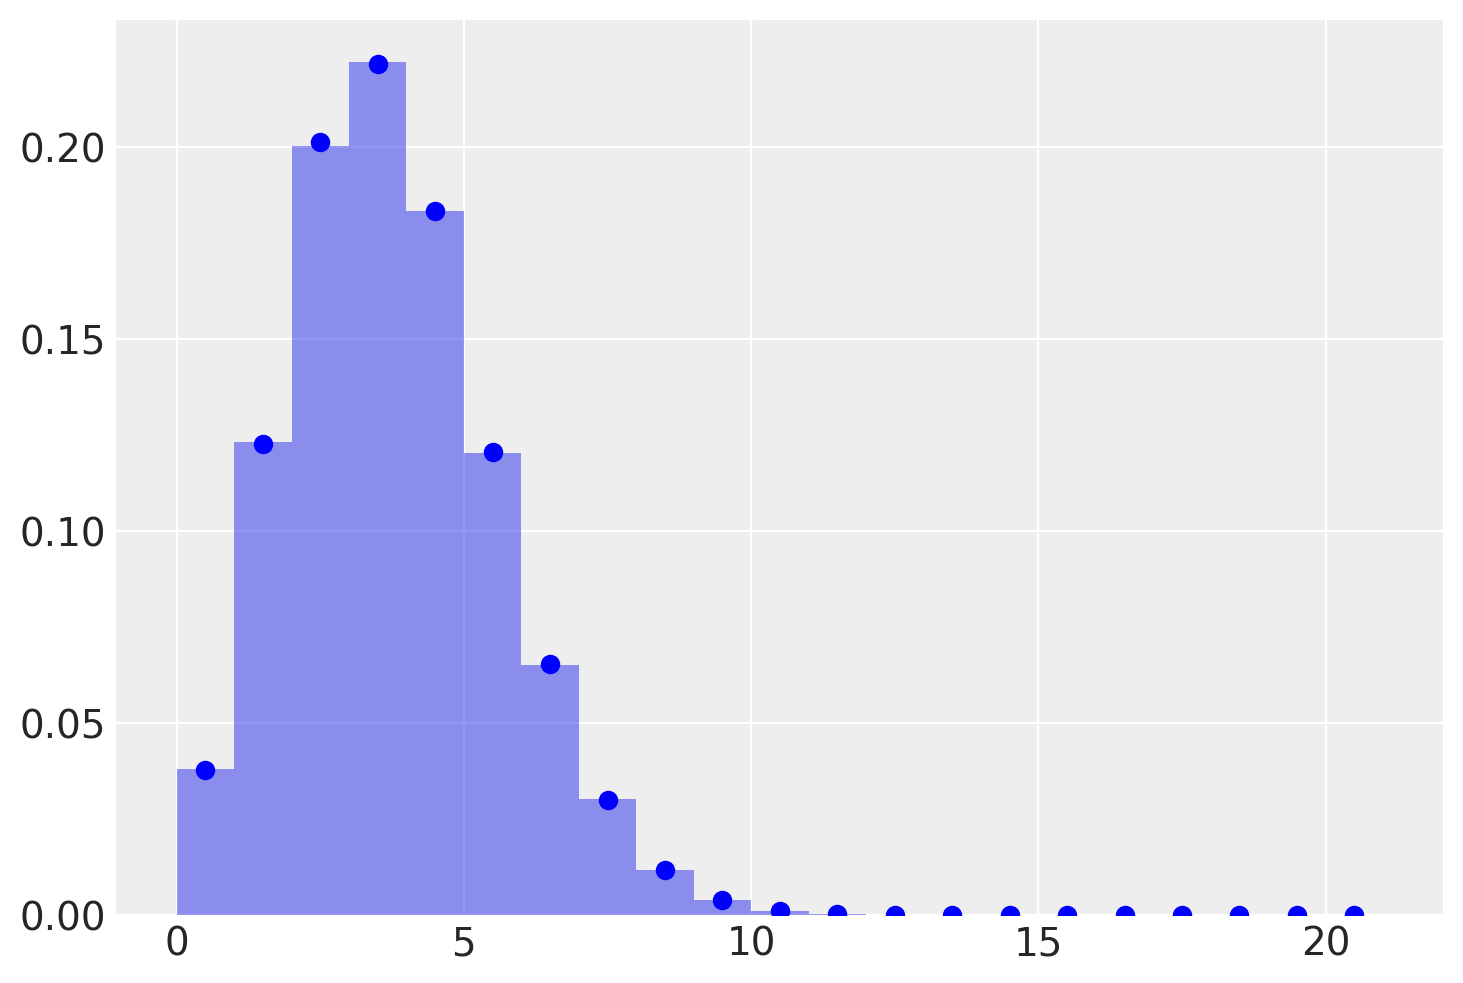

In [50]:
hist, bins, _ = plt.hist(y_tilde, bins=range(0, 22), density=True, alpha=0.5)
bin_centers = (bins[:-1] + bins[1:]) / 2
px = stats.betabinom.pmf(np.arange(0, 21), m, alpha_prime, beta_prime)
plt.plot(bin_centers, px, "o", color="blue", label="Beta-Binomial");

Un intervallo di credibilità all'80% si può facilmente ottenere usando ArviZ.

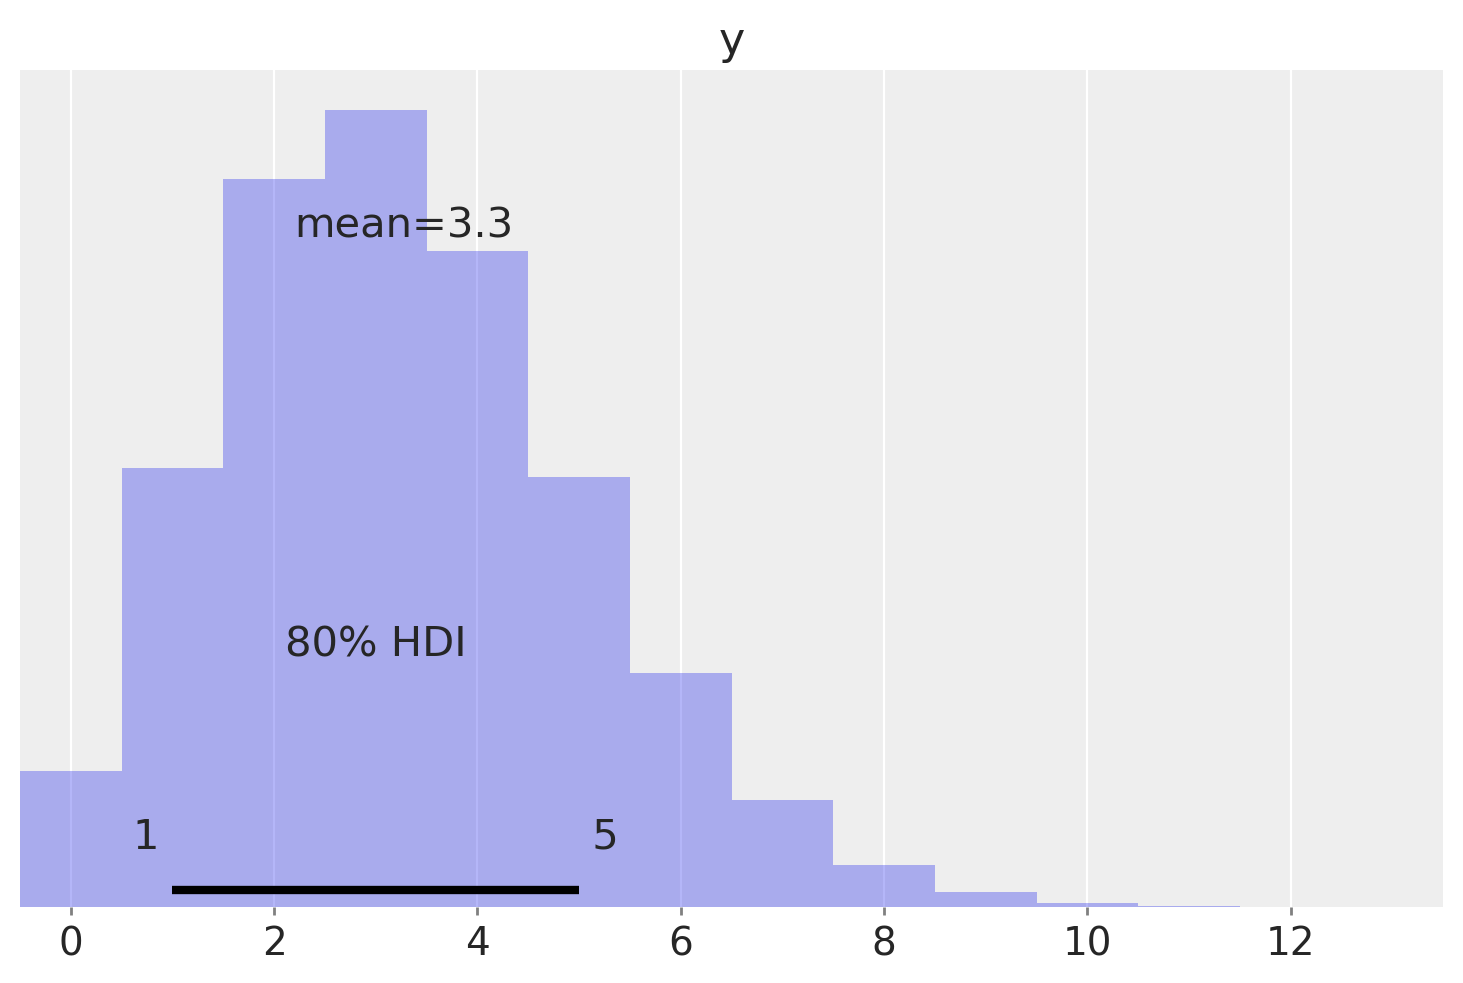

In [55]:
# Create a dictionary with the data
data_dict = {"y": y_tilde}

# Create the plot using ArviZ
az.plot_posterior(data_dict, hdi_prob=0.8, kind="kde", bw=0.5);

Possiamo concludere affermando che, nel caso in cui analizzassimo un nuovo campione di 20 artisti provenienti dal MOMA, ci potremmo attendere che solamente 3 di questi artisti facciano parte della generazione X o di una generazione successiva. Tuttavia, è importante sottolineare che questa stima è soggetta a un certo grado di incertezza. Considerando un livello di fiducia soggettivo dell'80%, l'intervallo di variabilità stimato va da un minimo di 1 ad un massimo di 5 artisti, che potrebbero essere rappresentativi di queste generazioni successive. 

## Metodo MCMC

Il metodo di simulazione discusso sopra segue la stessa logica utilizzata dai metodi MCMC per ottenere un'approssimazione della distribuzione predittiva a posteriori. Mediante i metodi MCMC, vengono stimate le possibili osservazioni future $p(\tilde{y} \mid y)$, rappresentate come $p(y^{rep} \mid y)$, attraverso i seguenti passaggi:

1. Campionare $\theta_i \sim p(\theta \mid y)$: Viene selezionato casualmente un valore del parametro dalla distribuzione a posteriori.
2. Campionare $y^{rep} \sim p(y^{rep} \mid \theta_i)$: Viene selezionata casualmente un'osservazione dalla funzione di verosimiglianza, condizionata al valore del parametro ottenuto nel passo precedente.

Ripetendo questi due passaggi un numero sufficiente di volte, l'istogramma risultante approssimerà la distribuzione predittiva a posteriori. In alcuni casi, come nel presente esempio, è possibile ottenere analiticamente la distribuzione predittiva a posteriori. In altre situazioni, invece, l'utilizzo dei metodi MCMC consente di ottenere un'approssimazione accurata della distribuzione predittiva a posteriori quando una derivazione analitica non è possibile.

Esaminiamo ora come ottenere la distribuzione predittiva a posteriori con PyMC per i dati dell'esempio. Iniziamo a creare la distribuzione a posteriori di $\theta$.

In [77]:
ntrials = 100
y = 14

alpha_prior = 4
beta_prior = 6

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Il processo della simulazione descritta in precedenza può essere automatizzato usando PyMC, ma solo per un campione futuro avente la stessa ampiezza del campione presente ($n = m$ = 100). Le istruzioni necessarie per generare la distribuzione predittiva a posteriori, $y^{rep} \sim p(y^{rep} \mid \theta_i)$ sono fornite di seguito.

In [58]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs]


Esaminiamo il risultato ottenuto.

In [59]:
post_pred.posterior_predictive.obs

<xarray.DataArray 'obs' (chain: 4, draw: 1000)>
array([[15, 14, 21, ..., 29, 18, 23],
       [20, 15, 15, ..., 13, 15, 17],
       [21, 16, 23, ..., 25, 19, 27],
       [23, 14, 10, ..., 16, 19, 22]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

Creiamo un istogramma con i dati $y^{rep}$. L'intervallo di credibilità dell'80% è [8, 21].

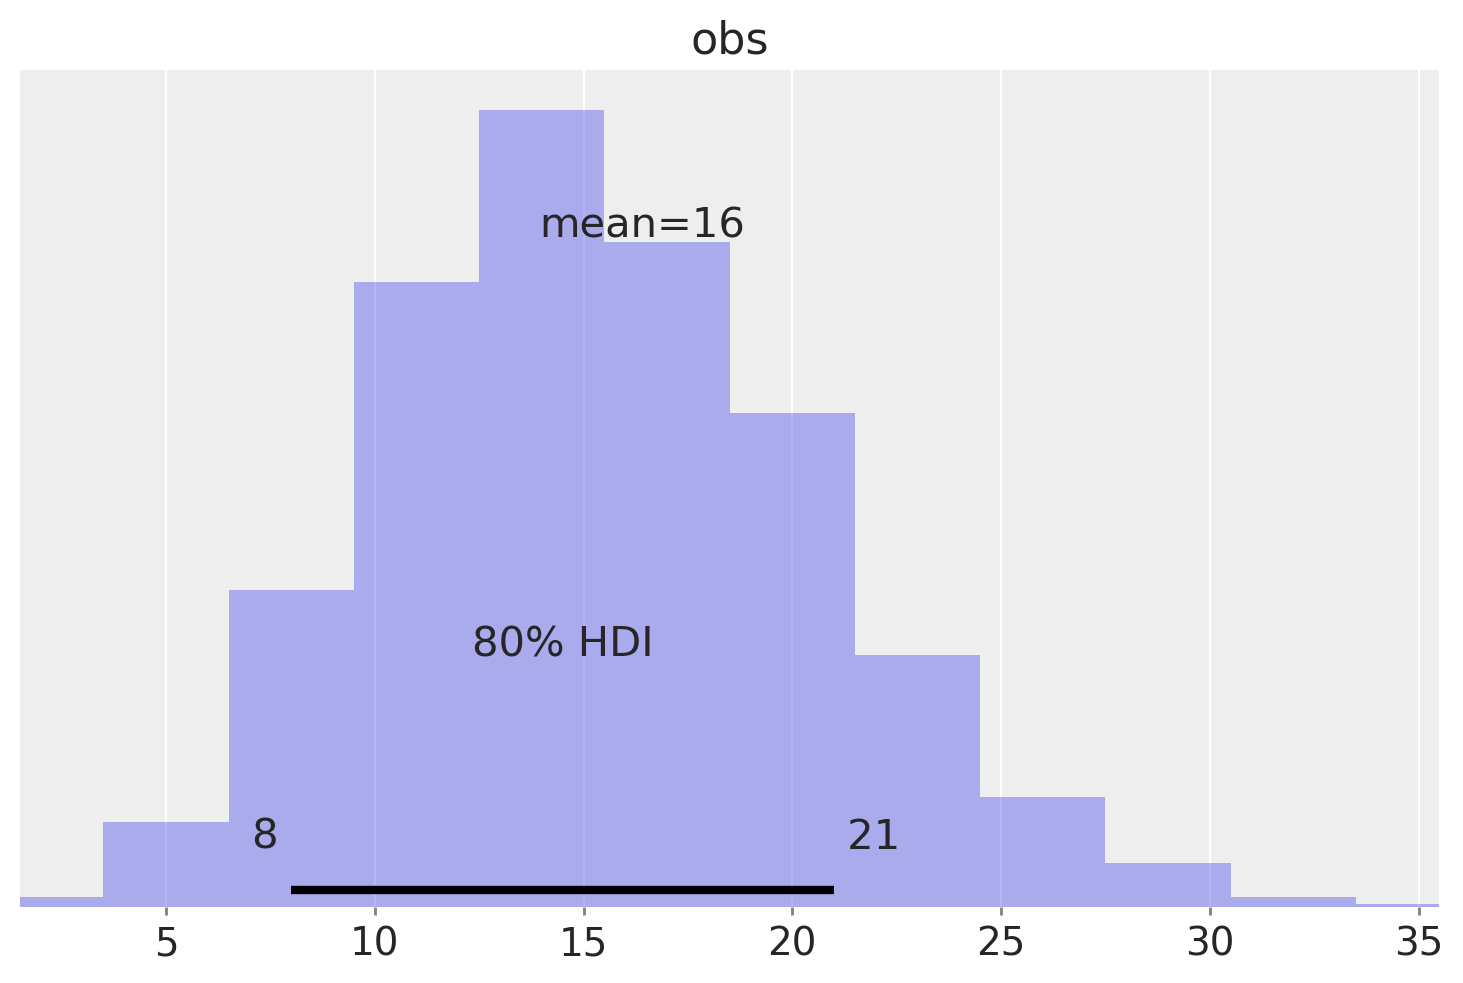

In [61]:
az.plot_posterior(post_pred.posterior_predictive.obs, hdi_prob=0.8);

Se invece vogliamo una distribuzione predittiva a posteriori nel caso di $m$ = 20 dobbiamo procedere svolgendo i calcoli "manualmente".

Il modello predittivo a posteriori riflette due fonti di variabilità:

- la prima fonte di variabilità riguarda la varianza della distribuzione binomiale $\tilde{Y} \mid \pi \sim \text{Binomiale}(20, \pi)$;
- la seconda fonte di variabilità riguarda l'incertezza su $\pi$ che è espressa dalla distribuzione a posteriori di questo parametro.

Per considerare entrambe le fonti di variabilità nelle previsioni a posteriori di $\tilde{Y}$, possiamo impiegare `stats.binom.rvs` per simulare un singolo risultato $\tilde{Y}$ dalla distribuzione Binomiale(20, $\theta$) per ciascuno dei 4000 valori nella catena di Markov relativa a $\theta$.

Iniziamo combinando catene e iterazioni della catena di Markov in un unico vettore.

In [83]:
post = az.extract(idata)
post["theta"].size

4000

Generiamo poi un valore casuale dalla distribuzione Binomiale di parametri $n$ = 20 e $\theta$, per ciascuno dei 4000 valori $\theta$ della distribuzione a posteriori. Il vettore così risultante sarà un campione dalla distribuzione predittiva a posteriori, nel caso di un'ampiezza campionaria pari a 20.

In [86]:
y_rep = stats.binom.rvs(n=20, p=post["theta"])

Usiamo ArviZ per creare un istogramma della distribuzione di `y_rep` e per trovare l'intervallo di credibilità all'80%.

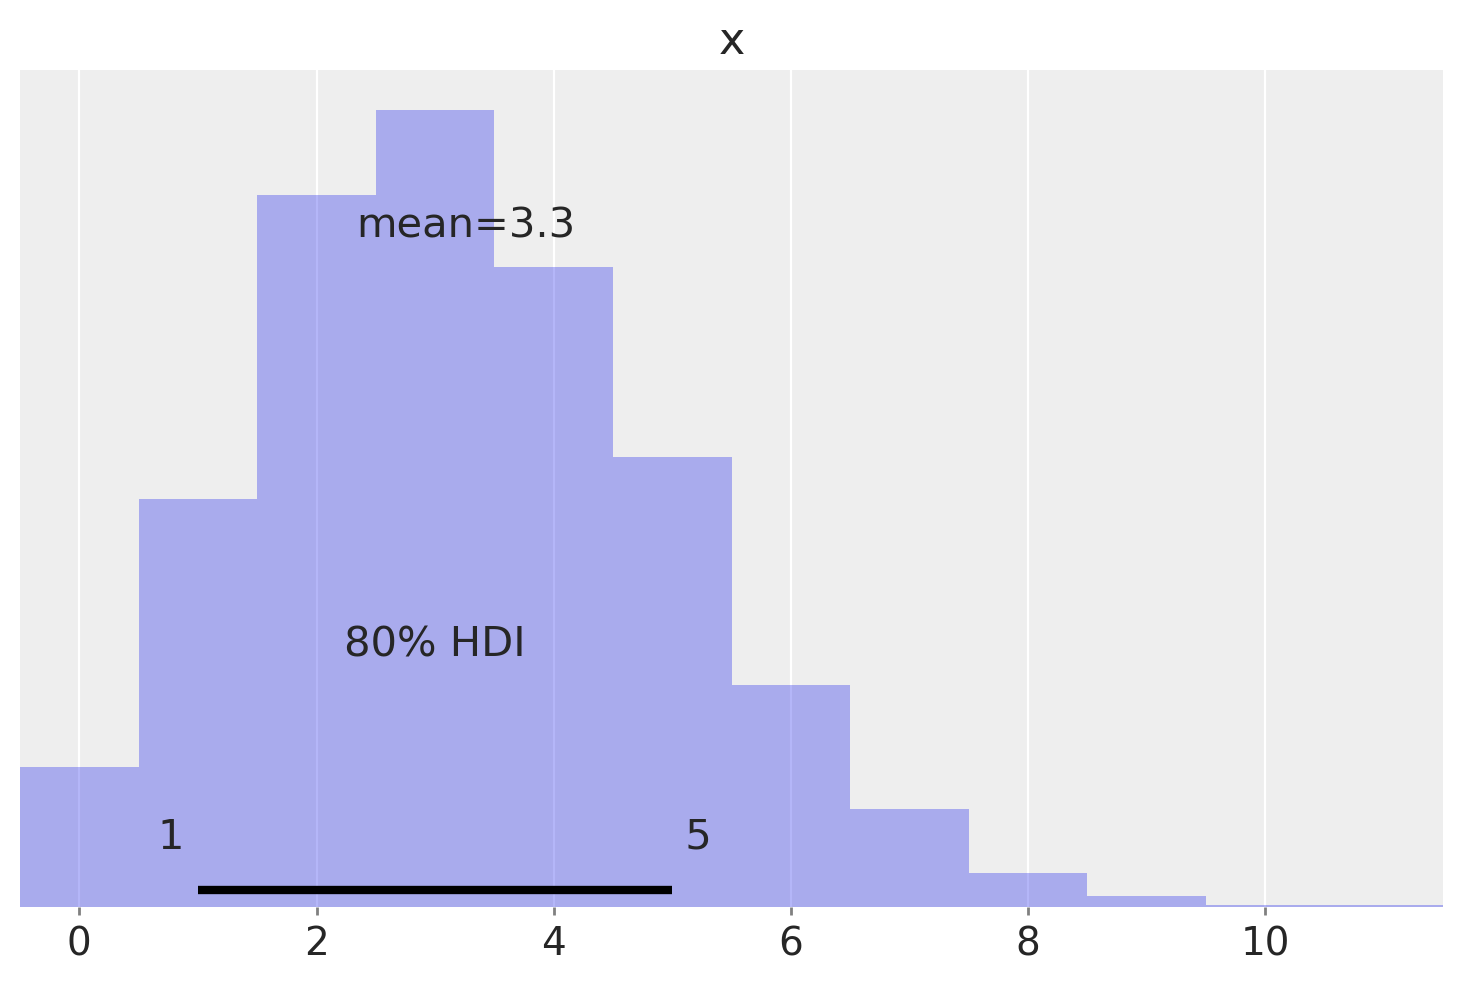

In [88]:
az.plot_posterior(y_rep, hdi_prob=0.8, kind="kde", bw=0.5);

### Posterior predictive checks

La distribuzione predittiva a posteriori è utilizzata per eseguire i *controlli predittivi a posteriori* (PPC), noti come *Posterior Predictive Checks*. I PPC consistono in un confronto grafico tra $p(y^{rep} \mid y)$, ossia la distribuzione delle osservazioni future previste, e i dati osservati $y$. Questo confronto visivo permette di valutare se il modello utilizzato è adeguato per descrivere le proprietà dei dati osservati.

Oltre al confronto grafico tra le distribuzioni $p(y)$ e $p(y^{rep})$, è possibile effettuare un confronto tra le distribuzioni di varie statistiche descrittive calcolate su diversi campioni $y^{rep}$ e le corrispondenti statistiche calcolate sui dati osservati. Tipicamente, vengono considerate statistiche descrittive come la media, la varianza, la deviazione standard, il minimo o il massimo, ma è possibile confrontare qualsiasi altra statistica rilevante.

I controlli predittivi a posteriori offrono un valido strumento per un'analisi critica delle prestazioni del modello e, se necessario, per apportare eventuali modifiche o considerare modelli alternativi più adatti ai dati in esame.

## Distribuzione predittiva a priori

Nella sezione precedente abbiamo esaminato come la distribuzione predittiva venga utilizzata per generare previsioni sui dati futuri. In particolare, l'equazione {eq}`eq-post-pred-distr` descrive la nostra incertezza riguardo alla distribuzione delle future osservazioni di dati, tenendo conto della distribuzione a posteriori di $\theta$ e della scelta del modello basata sui dati osservati. 

Una seconda forma in cui si manifesta la predizione bayesiana è quella della *distribuzione predittiva a priori*, che descrive la distribuzione dei dati futuri previsti dal modello prima di aver osservato il campione $y$. Se i dati osservati $y$ non sono coerenti con la distribuzione predittiva a priori, ciò implica che il modello bayesiano (cioè, la scelta della distribuzione a priori, la scelta del meccanismo generatore dei dati o entrambi) non è specificato correttamente. In altre parole, questo suggerisce che, secondo il modello bayesiano formulato, è improbabile che si verifichino i dati che sono stati effettivamente osservati. Questo indica chiaramente che il modello è inadeguato.

La distribuzione predittiva a priori può essere facilmente ottenuta se l'inferenza è svolta mediante i metodi MCMC. Per ottenere la distribuzione predittiva a priori, si replica la procedura usata per la generazione della distribuzione predittiva a posteriori, ma senza includere alcuna informazione relativa ai dati osservati. In altre parole, si utilizza la distribuzione a priori senza considerare i dati osservati, fornendo una stima della distribuzione dei dati futuri previsti dal modello prima di osservare il campione attuale.

Se ritorniamo all'esempio con i dati di {cite:t}`zetsche_2019future`, è importante ricordare che abbiamo scelto una distribuzione Beta(2, 10) come distribuzione a priori. Tuttavia, eseguendo l'analisi predittiva a priori, ci rendiamo facilmente conto che questa scelta di distribuzione (Beta(2, 10)) non è adeguata per i dati considerati. 

In [72]:
with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)
    idata_prior_pred = pm.sample_prior_predictive(samples=2000, random_seed=rng)

Sampling: [obs, theta]


In [73]:
idata_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

I dati (sulla scala delle osservazioni $y$) sono contenuti in `idata.prior_predictive.obs`. Possiamo usare `arviz` per generare un istogramma della distribuzione predittiva a priori:

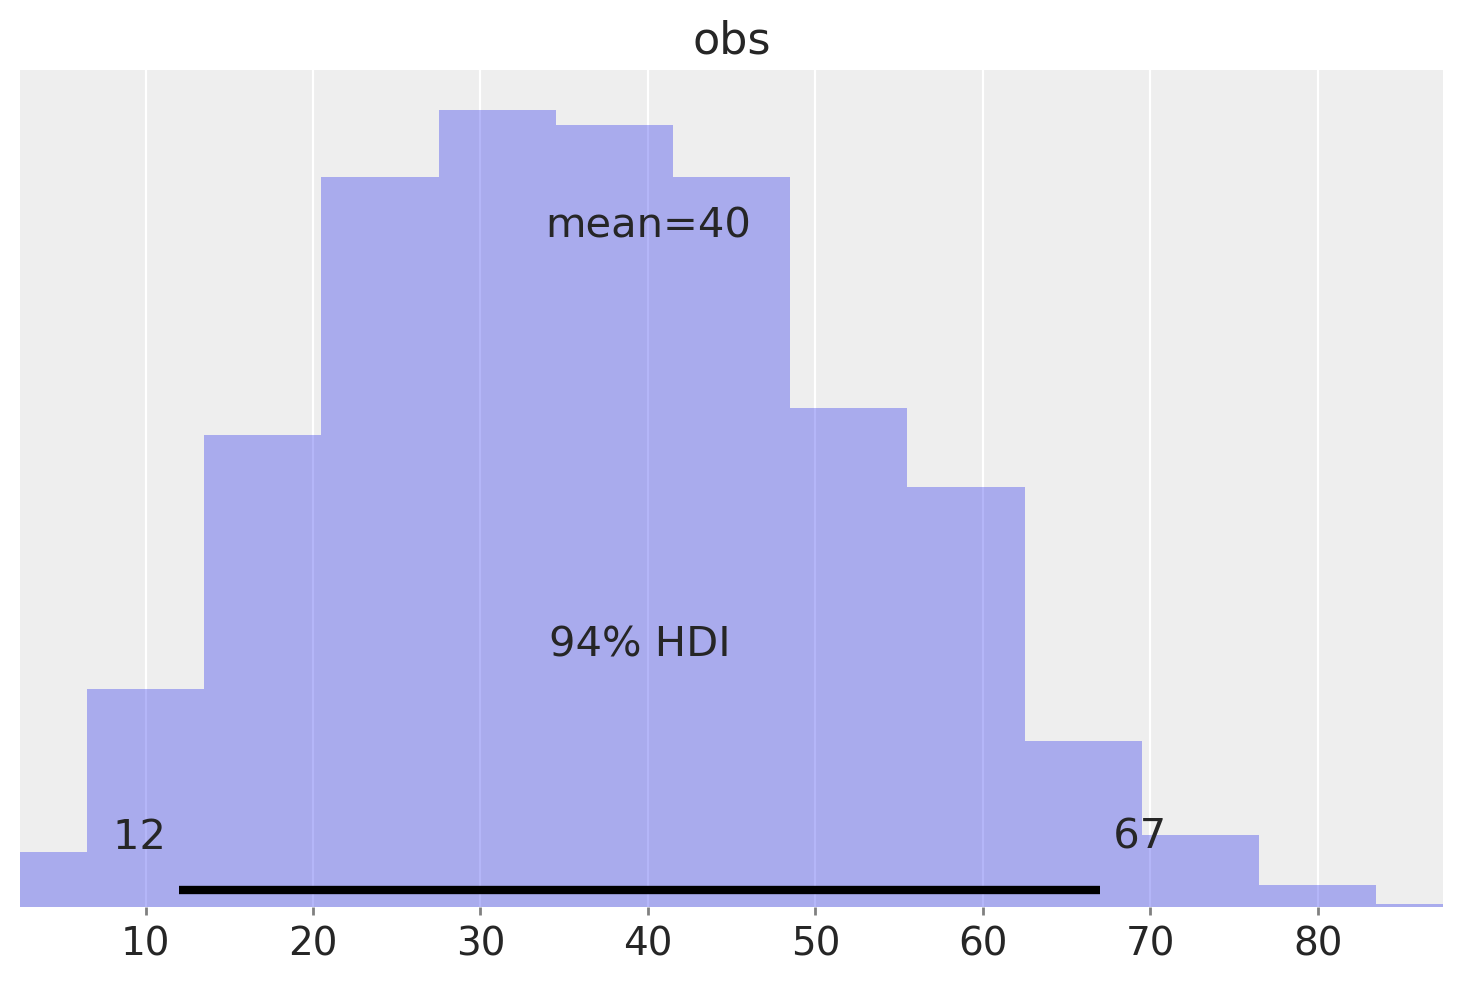

In [75]:
az.plot_posterior(idata_prior_pred.prior_predictive.obs);

La regione HDI al 94% è [12, 67]. Nel campione abbiamo osservato $y$ = 14. Questo risultato è incluso nell'intervallo di credibilità della distribuzione predittiva a priori, il che suggerisce che la distribuzione Beta(4, 6) sia adeguata come distribuzione a priori per i nostri dati.

## Watermark

In [76]:
%watermark -n -u -v -iv -w

Last updated: Mon Aug 07 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

scipy     : 1.11.1
matplotlib: 3.7.1
arviz     : 0.16.1
pymc      : 5.7.1
numpy     : 1.25.2
pandas    : 2.0.3

Watermark: 2.4.3

